In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vega_datasets import data
import altair as alt
import seaborn as sns

In [18]:
df_county_gov_fin = pd.read_excel("data/County_Govt_Finances.xlsx")
df_county_gov_fin.columns

Index(['Sort_Code', 'Survey Year', 'Year4', 'ID', 'GID_Compatible_ID',
       'State Code', 'Type Code', 'County Code', 'Name', 'Census Region Code',
       'FIPS Code_State', 'FY Ending Date', 'Year of Data',
       'Year of Retirement Data', 'Year of Pop Data', 'Not Available Flag',
       'Version', 'Revise Date', 'Data Flag', 'Large County Flag',
       'Source Code', 'Imputed Record', 'Population', 'Total Revenue',
       'Total Rev-Own Sources', 'General Revenue', 'Gen Rev-Own Sources',
       'Total Taxes', 'Property Tax (T01)', 'NonProperty Taxes',
       'Total IG Revenue', 'Total State IG Revenue', 'Tot Chgs and Misc Rev',
       'Total General Charges', 'Misc General Revenue',
       'Liquor Stores Revenue (A90)', 'Total Utility Revenue',
       'Water Utility Revenue (A91)', 'Nonwater Utility Rev',
       'Total Emp Ret Rev', 'Emp Ret-Loc To Loc Sys (X04)',
       'Total Expenditure', 'Total IG Expenditure', 'Direct Expenditure',
       'Total Current Oper', 'Total Capital 

# Interactive


In [19]:
# Pre-process Internal State Ids to FIPS standard map
state_codes_key = pd.read_excel(
    "data/GOVS_to_FIPS_Codes_State_&_County_2007.xls",
    sheet_name="State Codes",
    header=7,  # trim info header
    dtype=str,
    names=[
        "GOV_STATE_CODE",
        "STATE_NAME",
        "FIPS_STATE_CODE",
    ],
)
state_codes_key.reset_index(inplace=True, drop=True)

state_codes_key["STATE_NAME"] = state_codes_key["STATE_NAME"].str.title()

state_codes_key.tail()

,GOV_STATE_CODE,STATE_NAME,FIPS_STATE_CODE
46,47,Virginia,51
47,48,Washington,53
48,49,West Virginia,54
49,50,Wisconsin,55
50,51,Wyoming,56


In [20]:
# Pre-process Internal State & County Ids to FIPS standard map

# https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt


# this maps internal gov county & state codes to FIPS standard
county_codes_key = pd.read_excel(
    "data/GOVS_to_FIPS_Codes_State_&_County_2007.xls",
    sheet_name="County Codes",
    header=14,  # trim info header
    dtype=str,
    # Readable names
    names=[
        "GOV_ID",
        "GOV_STATE_CODE",
        "GOV_COUNTY_CODE",
        "COUNTY_NAME",
        "FIPS_STATE_CODE",
        "FIPS_COUNTY_02",
        "FIPS_COUNTY_07",
    ],
)


# Remove Nan index
county_codes_key.reset_index(inplace=True, drop=True)

# Trim info footer
county_codes_key = county_codes_key.iloc[:3223, :]
county_codes_key.tail()

county_codes_key["COUNTY_NAME"] = county_codes_key["COUNTY_NAME"].str.title()


# the full code is the 2 digit state fips plus the county fips
county_codes_key["FIPS"] = county_codes_key[
    "FIPS_STATE_CODE"
] + county_codes_key["FIPS_COUNTY_07"].astype(str)
county_codes_key["FIPS_NO_LEADING"] = county_codes_key["FIPS"].apply(
    lambda x: x[1:] if x[0] == "0" else x
)  # remove leading zero for lookup
county_codes_key["FIPS_NO_LEADING"].tail()

3218    56037
3219    56039
3220    56041
3221    56043
3222    56045
Name: FIPS_NO_LEADING, dtype: object

In [21]:
# Join the two together

df_state_county_key = county_codes_key.merge(
    state_codes_key,
    on="FIPS_STATE_CODE",
    how="left",  # left keeps all the rows from the county key
)
df_state_county_key.head()

,GOV_ID,GOV_STATE_CODE_x,GOV_COUNTY_CODE,COUNTY_NAME,FIPS_STATE_CODE,FIPS_COUNTY_02,FIPS_COUNTY_07,FIPS,FIPS_NO_LEADING,GOV_STATE_CODE_y,STATE_NAME
0,00000,00,000,United States,00,000,000,00000,0000,NaN,NaN
1,01000,01,000,Alabama,01,000,000,01000,1000,01,Alabama
2,01001,01,001,Autauga,01,001,001,01001,1001,01,Alabama
3,01002,01,002,Baldwin,01,003,003,01003,1003,01,Alabama
4,01003,01,003,Barbour,01,005,005,01005,1005,01,Alabama


### Columns of interest

- Health-Total Expend
- Health & Hosp-Tot Exp
- Total Hospital-Tot Exp
- Public Welf-Total Exp
- Population


In [22]:
# Need to get these metrics per capita


# Per the _Finance_Publication_Data_Guide.xls the population of counties is a whole number
# while finances are still in thousands
df_county_gov_fin["Health_Per_Capita"] = (
    df_county_gov_fin["Health-Total Expend"] * 1000
) / df_county_gov_fin["Population"]

df_county_gov_fin["Health_Hosp_Per_Capita"] = (
    df_county_gov_fin["Health & Hosp-Tot Exp"] * 1000
) / df_county_gov_fin["Population"]

df_county_gov_fin["Public_Welfare_Per_Capita"] = (
    df_county_gov_fin["Public Welf-Total Exp"] * 1000
) / df_county_gov_fin["Population"]

# the finance data in some of the earliest years uses negative values instead of Nan so this filters those
df_county_gov_fin = df_county_gov_fin[
    df_county_gov_fin["Health_Per_Capita"] > 0
]
df_county_gov_fin = df_county_gov_fin[
    df_county_gov_fin["Health_Hosp_Per_Capita"] > 0
]
df_county_gov_fin = df_county_gov_fin[
    df_county_gov_fin["Public_Welfare_Per_Capita"] > 0
]

# internal gov id which is not to be confused with fips which is very confusing
df_county_gov_fin["GOV_ID"] = df_county_gov_fin["State Code"].astype(
    str
).str.zfill(2) + df_county_gov_fin["County Code"].astype(str).str.zfill(3)

df_county_gov_fin[
    [
        "GOV_ID",
        "Year4",
        "Health_Per_Capita",
        "Health_Hosp_Per_Capita",
        "Public_Welfare_Per_Capita",
        "Name",
    ]
]

,GOV_ID,Year4,Health_Per_Capita,Health_Hosp_Per_Capita,Public_Welfare_Per_Capita,Name
0,01002,2006,7.817401,7.817401,2.183460,BALDWIN
1,01008,2006,1.810221,1.810221,0.517206,CALHOUN
6,01023,2006,1.723148,1.723148,5.066875,DALE
7,01024,2006,3.358428,3.358428,1.420006,DALLAS
8,01028,2006,1.754063,1.754063,3.227088,ETOWAH
...,...,...,...,...,...,...
89564,51017,1957,0.594501,23.680951,21.699282,SHERIDAN
89566,51019,1957,1.408003,22.300949,12.126993,SWEETWATER
89567,51020,1957,1.928268,1.928268,13.112225,TETON
89568,51021,1957,1.636884,19.506207,14.595553,UINTA


In [23]:
# I tried doing a standard lookup but transform_lookup has a maximum rows
# so this pivot table will act as a map for year to health spend for a county
df_county_gov_fin_piv = df_county_gov_fin.pivot_table(
    index=["GOV_ID"],
    columns="Year4",
    values="Health_Per_Capita",
).reset_index()

# df_county_gov_fin[["Health_Hosp_Per_Capita"]]
df_county_gov_fin_piv.columns = [
    str(name) for name in df_county_gov_fin_piv.columns
]
df_county_gov_fin_piv.head()

,GOV_ID,1957,1962,1967,1970,1971,1972,1973,1974,1975,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,01001,NaN,NaN,0.570175,0.654129,0.695012,6.255110,6.541292,NaN,NaN,...,2.196650,NaN,NaN,2.381443,NaN,2.381443,NaN,NaN,NaN,NaN
1,01002,NaN,1.690841,NaN,NaN,NaN,NaN,0.791486,0.467421,1.635973,...,2.178454,2.706811,2.56723,3.183421,3.154934,9.108713,7.841441,6.638185,11.679972,7.817401
2,01003,NaN,NaN,1.284047,NaN,NaN,2.927738,NaN,NaN,NaN,...,0.302172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01004,0.889531,NaN,1.456954,NaN,NaN,2.751231,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01005,NaN,0.314354,0.338346,0.484117,0.521357,0.558597,0.446877,NaN,NaN,...,0.530052,NaN,NaN,0.529163,2.018658,1.940263,2.190002,2.208881,2.960969,NaN


In [24]:
df_merge_data = df_state_county_key.merge(
    df_county_gov_fin_piv, on="GOV_ID", how="left"
)

In [25]:
counties_geo = alt.topo_feature(data.us_10m.url, "counties")
states_geo = alt.topo_feature(data.us_10m.url, "states")


year_slider = alt.binding_range(
    min=df_county_gov_fin["Year4"].min(),
    max=df_county_gov_fin["Year4"].max(),
    step=1,
    name="Year: ",
)

year_select = alt.selection_point(
    name="year_select",
    fields=["Year4"],
    bind=year_slider,
    value=df_county_gov_fin["Year4"].max(),
)

# so d3 doesn't have a built in hatch pattern thats easy to use for null values
# i decided to do 2 layers a valid layer and an invalid layer
# the invalid layer is dashed outline which resembles a hatch pattern
county_map_heath_exp = (
    alt.Chart(counties_geo)
    .mark_geoshape()
    .add_params(year_select)
    .transform_lookup(
        lookup="id",
        from_=alt.LookupData(
            df_merge_data,
            key="FIPS_NO_LEADING",
            fields=[
                "COUNTY_NAME",
                "STATE_NAME",
                "GOV_ID",
                *df_county_gov_fin_piv.columns,
            ],
        ),
    )
    .transform_calculate(
        health_exp_per_cap="datum[toString(year_select.Year4)]",
        valid="isValid(datum[toString(year_select.Year4)])",
    )
)

count_map_valid = county_map_heath_exp.transform_filter(
    "datum.valid == true"
).encode(
    color=alt.Color(
        "health_exp_per_cap:Q",
        title="Health Expenditure Per Capita",
        scale=alt.Scale(
            scheme="viridis",
            domain=[
                0,
                df_county_gov_fin["Health_Per_Capita"].quantile(
                    0.99
                ),  # remove outliers
            ],
        ),
    ),
    tooltip=[
        alt.Tooltip("id:N"),
        alt.Tooltip("COUNTY_NAME:N", title="County"),
        alt.Tooltip("STATE_NAME:N", title="State"),
        alt.Tooltip(
            "health_exp_per_cap:Q", title="Health Expenditure Per Capita"
        ),
    ],
)
count_map_invalid = (
    county_map_heath_exp.transform_filter("datum.valid == false")
    .mark_geoshape(
        fill="#ffffff",
        stroke="#d00000e0",
        strokeWidth=1,
        strokeDash=[4, 2],
    )
    .encode(
        tooltip=[
            alt.Tooltip("id:N"),
            alt.Tooltip("COUNTY_NAME:N", title="County"),
            alt.Tooltip("STATE_NAME:N", title="State"),
            alt.Tooltip(
                "health_exp_per_cap:Q", title="Health Expenditure Per Capita"
            ),
        ]
    )
)

state_map = alt.Chart(states_geo).mark_geoshape(
    fill=None,
    stroke="black",
    strokeWidth=1,
)

chart = (
    (count_map_valid + count_map_invalid + state_map)
    .project("albersUsa")
    .properties(
        width=900,
        height=500,
        title="Health Expenditures by County 1957 to 1960",
    )
    .configure_view(stroke=None)
)

chart.save("county_map.html")

# Analyze

- Health-Total Expend
- Health & Hosp-Tot Exp
- Total Hospital-Tot Exp
- Public Welf-Total Exp
- Population


In [26]:
df_obesity = pd.read_csv("USStatistics(2020-2023).csv")
df_codes = pd.read_csv("data/state-to-code.csv")
df_obesity = df_obesity.merge(df_codes, on="State", how="left")
df_obesity["Year"].unique()

array([2020, 2021, 2022, 2023])

In [27]:
# Get average obesity rate for each state for 2021 to 2023
df_obesity_cleaned = df_obesity[df_obesity["Year"].isin([2021, 2022, 2023])]
df_obesity_avg = (
    df_obesity_cleaned.groupby("Code")["Obesity Rate"].mean().reset_index()
)
df_obesity_cleaned.dropna(inplace=True)
df_obesity_avg.columns = ["Code", "Avg_Obesity_Rate"]
df_avg_sorted = df_obesity_avg.sort_values("Avg_Obesity_Rate", ascending=False)
state_order = df_avg_sorted["Code"].tolist()
df_obesity_cleaned = df_obesity_cleaned.merge(
    df_obesity_avg, on="Code", how="left"
)
df_obesity_cleaned.to_csv("data/df_obesity_poverty.csv", index=False)
df_obesity_cleaned.head()

C:\Users\russj\AppData\Local\Temp\ipykernel_32236\867941138.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obesity_cleaned.dropna(inplace=True)


,State,Year,Obesity Rate,Poverty Rate,Median Income,Region,Code,Avg_Obesity_Rate
0,Alabama,2021,39.9,16.3,53990,South,AL,39.133333
1,Alabama,2022,38.3,16.2,59703,South,AL,39.133333
2,Alabama,2023,39.2,15.7,62248,South,AL,39.133333
3,Alaska,2021,33.5,10.8,78437,West,AK,33.600000
4,Alaska,2022,32.1,10.8,88072,West,AK,33.600000


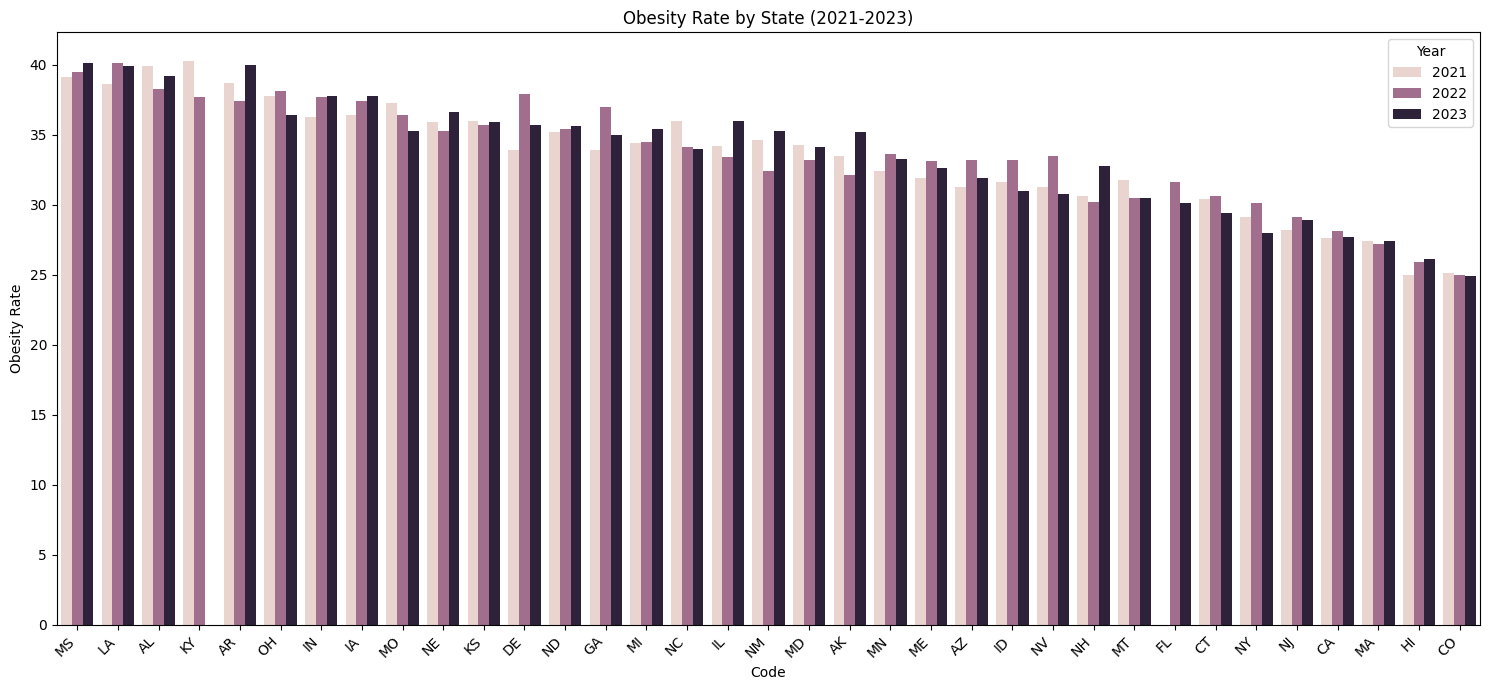

In [28]:
# going to convert something like this to a D3 Graph
plt.figure(figsize=(15, 7))
sns.barplot(
    data=df_obesity_cleaned,
    x="Code",
    y="Obesity Rate",
    hue="Year",
    order=state_order,
)
plt.xticks(rotation=45, ha="right")
plt.title("Obesity Rate by State (2021-2023)")
plt.tight_layout()
plt.show()

In [29]:
# Process ASFIN data 2021-2023

df_asfin_2023 = pd.read_excel("data/asfin_2023.xlsx", header=4, index_col=0)
df_asfin_2022 = pd.read_excel("data/asfin_2022.xlsx", header=4, index_col=0)

## 2021 included 2020 and 2021 for some reason so needs the columns to be processed diff
df_temp = pd.read_excel("data/asfin_2021.xlsx", header=0)
data = {}
for i, col in enumerate(df_temp.columns):
    if i > 4 and (i - 2) % 3 == 0:
        # the layout of the file if 2021 2021 and the percent diff so we need to get every 3rd column after the first 4
        # the first for are the entirety of the USA which we dont need
        # print(i, df_temp.iloc[:, i])
        data[col] = df_temp.iloc[:, i]
df_asfin_2021 = pd.DataFrame(data)
df_asfin_2021.index = df_temp["(Thousands of Dollars)"]
df_asfin_2021.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
(Thousands of Dollars),,,,,,,,,,,,,,,,,,,,,
NaN,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,...,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021,FY2021
Total revenue,42744424,10389233,57705881,28213820,504381850,46751819,47470892,13932880,126292984,68300546,...,5828436,43381352,214868203,29984752,8419220,77518291,74134158,17735301,50260813,7505301
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General revenue,38326661,9178114,52047873,26644503,410636676,40076190,40117376,13045792,114029559,60932942,...,5205080,41714603,193789786,27404644,7838219,72187671,63376345,16194098,45328576,6375373
Intergovernmental revenue,15878493,5260485,25561976,10746792,116803579,14384700,12777730,5315164,42721773,26262760,...,2037206,17340564,88753054,7403999,2694118,24111868,21113014,6899273,14225073,3103070


In [30]:
df_ob = pd.read_csv("USStatistics(2020-2023).csv")
df_codes = pd.read_csv("data/state-to-code.csv")


# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
def process_asfin(df, year):
    df.index = df.index.str.strip()
    df.index = df.index.str.replace("\xa0", " ", regex=False).str.strip()
    filtered_df = df[
        (df.index == "Health")
        | (df.index == "Public welfare")
        | (df.index == "Education")
    ]

    # we want the states to become a column instead of header so transpose
    health_spend = filtered_df.T.reset_index()

    # convert stae index to column
    health_spend.rename(
        columns={health_spend.columns[0]: "State"}, inplace=True
    )

    health_spend.dropna(inplace=True)

    health_spend["State"] = health_spend["State"].astype(str).str.strip()
    health_spend = health_spend.merge(df_codes, on="State", how="left")
    # want in millions so it doesnt take up too much y axis space
    numeric_cols = ["Health", "Public welfare", "Education"]
    health_spend["Health"] = health_spend["Health"] * 0.001
    health_spend["Public welfare"] = health_spend["Public welfare"] * 0.001
    health_spend["Education"] = health_spend["Education"] * 0.001

    health_spend["Year"] = year

    return health_spend


health_spend_2021 = process_asfin(df_asfin_2021, 2021)
health_spend_2022 = process_asfin(df_asfin_2022, 2022)
health_spend_2023 = process_asfin(df_asfin_2023, 2023)
health_spend_combined = pd.concat(
    [health_spend_2021, health_spend_2022, health_spend_2023],
    ignore_index=True,
)

In [31]:
obestiy_analysis_final = df_obesity_cleaned.merge(
    health_spend_combined, on=["Code", "Year", "State"], how="left"
)
obestiy_analysis_final.to_csv("data/obesity_analysis_final.csv", index=False)